# Part 3: Identify 10,000 Medicare patients who are involved in anomalous activities. 

We need to analyze patient-level data for anomalies. This can involve:

    - Association Analysis – Identify unusual relationships in claims.
    - Clustering – Group patients and find those that do not fit normal clusters.
    - Graph-Based Analysis – Detect fraud rings or unusual connections between patients, providers, and transactions.
                                     
Explore Patient History and Transactions:

    - High Claim Frequency: Patients with excessive claims in a short period.
    - Unusual Transaction Patterns: Repeated claims with different providers.
    - High-Cost Claims: Patients with significantly higher billing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pyodbc

In [2]:
# Step 1: Connect to SQL Server
# Define connection parameters
server = 'DESKTOP-DGDUOBT\SQLEXPRESS'  
database = 'MedicareAnalysis'
username = ''  
password = ''  
driver = '{ODBC Driver 17 for SQL Server}'   

try:
    conn = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes')
    print("Connection successful!")
except Exception as e:
    print(f"Connection failed: {e}")

Connection successful!


In [3]:
# Step 2: Load data from SQL tables
Medicare_Charge_In = pd.read_sql_query("SELECT * FROM Medicare_Charge_Inpatient_DRG", conn)
Medicare_Charge_Out = pd.read_sql_query("SELECT * FROM Medicare_Charge_Outpatient_APC", conn)
Provider_Charge_In = pd.read_sql_query("SELECT * FROM Provider_Charge_Inpatient_DRG", conn)
Provider_Charge_Out = pd.read_sql_query("SELECT * FROM Provider_Charge_Outpatient_APC", conn)
Patient_history = pd.read_sql_query("SELECT * FROM Patient_history", conn)
Review_patient = pd.read_sql_query("SELECT * FROM Review_patient_history", conn)
Transaction = pd.read_sql_query("SELECT * FROM Transaction_", conn)
Review_transaction = pd.read_sql_query("SELECT * FROM Review_transaction", conn)

# Step 3: Close the connection after loading data
conn.close()
print("Data loaded successfully & connection closed.")

C:\Users\HP\AppData\Local\Temp\ipykernel_6192\2473003980.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Medicare_Charge_In = pd.read_sql_query("SELECT * FROM Medicare_Charge_Inpatient_DRG", conn)
C:\Users\HP\AppData\Local\Temp\ipykernel_6192\2473003980.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Medicare_Charge_Out = pd.read_sql_query("SELECT * FROM Medicare_Charge_Outpatient_APC", conn)
C:\Users\HP\AppData\Local\Temp\ipykernel_6192\2473003980.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Provider_Charge_

Data loaded successfully & connection closed.


C:\Users\HP\AppData\Local\Temp\ipykernel_6192\2473003980.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  Review_transaction = pd.read_sql_query("SELECT * FROM Review_transaction", conn)


In [4]:
print(f"Medicare_Charge_In: {Medicare_Charge_In.columns}")
print(f"Medicare_Charge_Out: {Medicare_Charge_Out.columns}")
print(f"Provider_Charge_In: {Provider_Charge_In.columns}")
print(f"Provider_Charge_Out: {Provider_Charge_Out.columns}")
print(f"Patient_history: {Patient_history.columns}")
print(f"Review_patient: {Review_patient.columns}")
print(f"Transaction: {Transaction.columns}")
print(f"Review_transaction: {Review_transaction.columns}")

Medicare_Charge_In: Index(['DRG_Definition', 'Total_Discharges', 'Average_Covered_Charges',
       'Average_Total_Payments', 'Average_Medicare_Payments'],
      dtype='object')
Medicare_Charge_Out: Index(['APC', 'Outpatient_Services', 'Average_Estimated_Submitted_Charges',
       'Average_Total_Payments'],
      dtype='object')
Provider_Charge_In: Index(['DRG_Definition', 'Provider_Id', 'Provider_Name',
       'Provider_Street_Address', 'Provider_City', 'Provider_State',
       'Provider_Zip_Code', 'Hospital_Referral_Region', 'Total_Discharges',
       'Average_Covered_Charges', 'Average_Total_Payments',
       'Average_Medicare_Payments'],
      dtype='object')
Provider_Charge_Out: Index(['APC', 'Provider_Id', 'Provider_Name', 'Provider_Street_Address',
       'Provider_City', 'Provider_State', 'Provider_Zip_Code',
       'Hospital_Referral_Region_HRR_Description', 'Outpatient_Services',
       'Average_Estimated_Submitted_Charges', 'Average_Total_Payments'],
      dtype='object')
Pat

## Step 1: Data Cleaning and Preparation

In [5]:
# Remove duplicates if any
Patient_history.drop_duplicates(inplace=True)
Review_patient.drop_duplicates(inplace=True)
Transaction.drop_duplicates(inplace=True)
Review_transaction.drop_duplicates(inplace=True)

In [6]:
Patient_history['age'].fillna(Patient_history['age'].mode()[0], inplace=True)
Patient_history['income'].fillna(Patient_history['income'].mode()[0], inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_6192\605323904.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Patient_history['age'].fillna(Patient_history['age'].mode()[0], inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_6192\605323904.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

In [7]:
# One hot-encoding for categorical columns
Patient_history_encoded = pd.get_dummies(Patient_history, columns=['age', 'gender', 'income'], drop_first=True)

## Step 2: Data Aggregation

#### 2.1 Create Transaction Features
**Create Dummy Variables for Transactions:**
    - Use the Transaction dataset to create dummy variables for each global_proc_id.
    - Group the data by id and count the occurrences of each procedure for both reviewed and unmarked patients.

In [8]:
# Create dummy variables for each global_proc_id in the Transaction dataset
transaction_dummies = pd.get_dummies(Transaction['global_proc_id'], prefix='proc', drop_first=True)

# Add patient id to the dummy DataFrame
transaction_dummies['id'] = Transaction['id']

# Group by patient id and sum the occurrences of each procedure
transaction_counts = transaction_dummies.groupby('id').sum().reset_index()

# Check the resulting transaction_counts DataFrame
print(transaction_counts.head())


      id  proc_2  proc_3  proc_4  proc_5  proc_6  proc_7  proc_8  proc_9  \
0   7561       0       0       0       0       0       0       0       0   
1   7619       0       0       0       0       0       0       0       0   
2  10479       1       0       0       0       0       0       0       1   
3  13515       0       0       0       0       0       0       0       0   
4  15213       0       0       0       0       0       0       0       0   

   proc_10  ...  proc_121  proc_122  proc_123  proc_124  proc_125  proc_126  \
0        0  ...         0         0         0         0         0         0   
1        0  ...         0         0         0         0         0         0   
2        0  ...         0         0         0         0         0         0   
3        0  ...         0         0         0         0         0         0   
4        0  ...         0         0         0         0         0         0   

   proc_127  proc_128  proc_129  proc_130  
0         0         0   

#### 2.2 Merge Datasets
**Add REVIEW_IND Flag:**
Create a new column in both Review_patient and Patient_history indicating whether the patient is reviewed (1 for reviewed, 0 for unmarked).

In [9]:
# Add REVIEW_IND flag to reviewed patients
Review_patient['REVIEW_IND'] = 1

# Add REVIEW_IND flag to unmarked patients
Patient_history['REVIEW_IND'] = 0


In [10]:
# Merge reviewed patients with unmarked patients
merged_data = pd.concat([Patient_history, Review_patient], ignore_index=True)

# Now, merge the transaction counts with the merged_data on 'id'
final_data = pd.merge(merged_data, transaction_counts, on='id', how='left')

# Fill any NaN values in the transaction counts with 0 (if a patient had no transactions)
final_data.fillna(0, inplace=True)

# Check the final merged DataFrame
print(final_data.head())


          id    age gender       income  REVIEW_IND  proc_2  proc_3  proc_4  \
0  306535165  65-74      F  24000-31999           0       0       0       0   
1  742231134  65-74      F       48000+           0       0       0       0   
2  928807201  75-84      M  24000-31999           0       0       0       0   
3   83686538    <65      F  32000-47999           0       1       0       0   
4  755607449  65-74      F       48000+           0       0       0       0   

   proc_5  proc_6  ...  proc_121  proc_122  proc_123  proc_124  proc_125  \
0       0       0  ...         0         0         0         1         0   
1       0       0  ...         0         0         0         0         0   
2       0       0  ...         0         0         0         0         0   
3       0       0  ...         0         0         0         0         0   
4       0       0  ...         0         0         0         0         0   

   proc_126  proc_127  proc_128  proc_129  proc_130  
0         0   

## Step 3: Balancing the Dataset

#### 3.1 Create Training Dataset

In [11]:
from sklearn.model_selection import train_test_split

# Sample 5000 unmarked patients
sampled_unmarked_patients = final_data[final_data['REVIEW_IND'] == 0].sample(n=5000, random_state=42)

# Combine reviewed and sampled unmarked patients to create the training dataset
training_data = pd.concat([final_data[final_data['REVIEW_IND'] == 1], sampled_unmarked_patients], ignore_index=True)

# Check the distribution of REVIEW_IND in the training dataset
print(training_data['REVIEW_IND'].value_counts())

REVIEW_IND
1    5000
0    5000
Name: count, dtype: int64


#### 3.2 Oversample with SMOTE

In [12]:
from imblearn.over_sampling import SMOTE

# Ensure to one-hot encode categorical variables in the training_data
training_data_encoded = pd.get_dummies(training_data, columns=['age', 'gender', 'income'], drop_first=True)

# Separate features and target variable after encoding
X = training_data_encoded.drop(columns=['id', 'REVIEW_IND'])  # Drop id and target variable
y = training_data_encoded['REVIEW_IND']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create a new DataFrame with the resampled data
resampled_data = pd.DataFrame(X_resampled, columns=X.columns)
resampled_data['REVIEW_IND'] = y_resampled

# Check the distribution of REVIEW_IND after SMOTE
print(resampled_data['REVIEW_IND'].value_counts())


REVIEW_IND
1    5000
0    5000
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_6192\3210567809.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  resampled_data['REVIEW_IND'] = y_resampled


## Step 4: Model Training

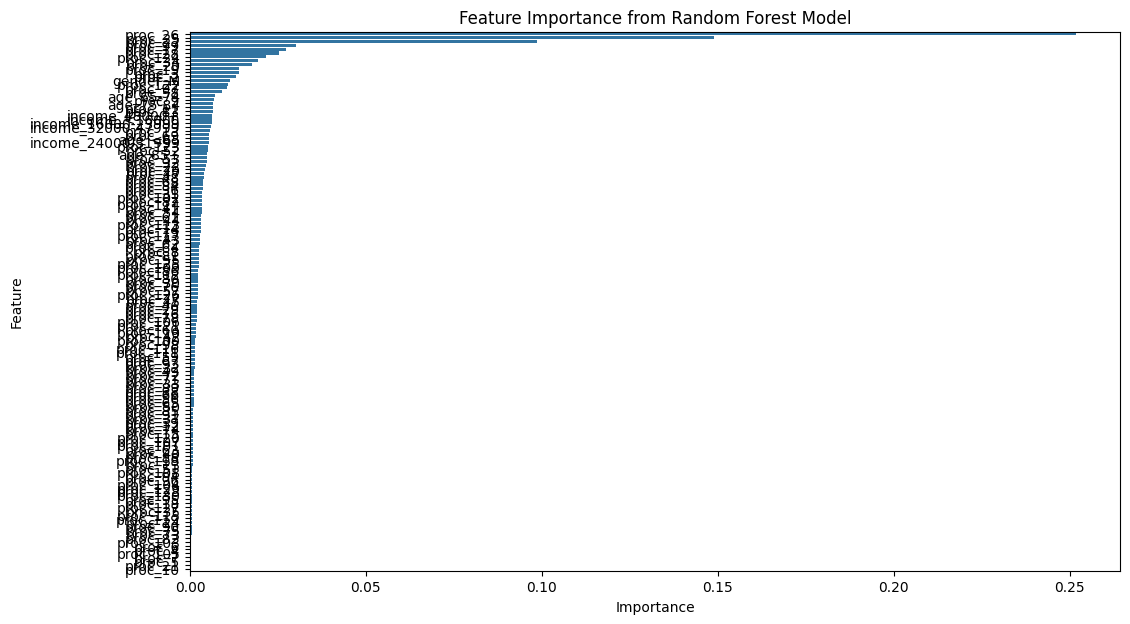

['proc_26',
 'proc_25',
 'proc_27',
 'proc_99',
 'proc_17',
 'proc_28',
 'proc_124',
 'proc_34',
 'proc_20',
 'proc_19']

In [13]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Train a Random Forest model to determine feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_resampled, y_resampled)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame to hold feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest Model')
plt.show()

# Select relevant features based on importance (e.g., top 10 features)
top_features = feature_importance_df.head(10)['Feature'].tolist()
top_features


In [14]:
# Filter the training data to include only the top features
X_train = X_resampled[top_features]

# Train the Random Forest model
rf_model_final = RandomForestClassifier(random_state=42)
rf_model_final.fit(X_train, y_resampled)

RandomForestClassifier(random_state=42)

Training Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.88      0.91      5000
           1       0.89      0.95      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



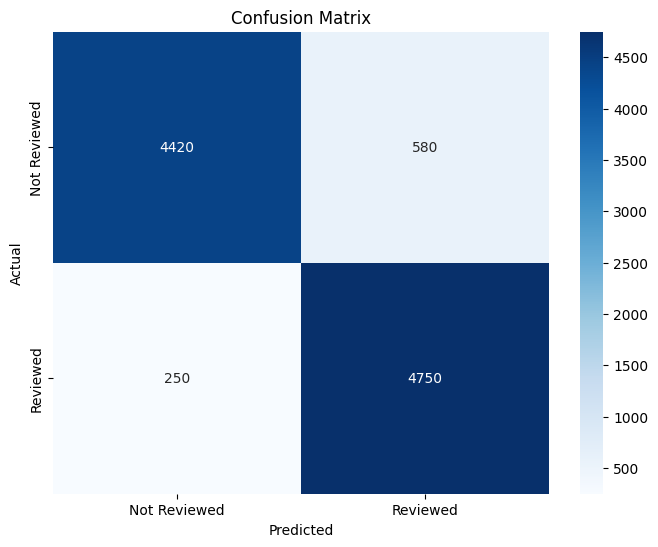

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predict on the training data
y_train_pred = rf_model_final.predict(X_train)

# Calculate accuracy
accuracy = accuracy_score(y_resampled, y_train_pred)
print(f"Training Accuracy: {accuracy:.2f}")

# Generate classification report
report = classification_report(y_resampled, y_train_pred)
print("Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_resampled, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Reviewed', 'Reviewed'], yticklabels=['Not Reviewed', 'Reviewed'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Step 5: Anomaly Detection

#### 11. Predict on Unmarked Patientsm

In [16]:
# Select test dataset (Unmarked patients only)
test_data = final_data[final_data['REVIEW_IND'] == 0].copy()

# Use the same top features used for training
X_test = test_data[top_features]

# Predict probabilities using the trained model
test_data['PREDICTED_PROB'] = rf_model_final.predict_proba(X_test)[:, 1]

# Predict labels based on threshold (default: 0.5)
test_data['PREDICTED_LABEL'] = (test_data['PREDICTED_PROB'] > 0.5).astype(int)

# Display sample results
print(test_data[['id', 'PREDICTED_PROB', 'PREDICTED_LABEL']].head())


          id  PREDICTED_PROB  PREDICTED_LABEL
0  306535165        0.000000                0
1  742231134        0.068313                0
2  928807201        0.068313                0
3   83686538        0.867327                1
4  755607449        0.000000                0


In [17]:
print(test_data.columns)


Index(['id', 'age', 'gender', 'income', 'REVIEW_IND', 'proc_2', 'proc_3',
       'proc_4', 'proc_5', 'proc_6',
       ...
       'proc_123', 'proc_124', 'proc_125', 'proc_126', 'proc_127', 'proc_128',
       'proc_129', 'proc_130', 'PREDICTED_PROB', 'PREDICTED_LABEL'],
      dtype='object', length=136)


#### 2. Identify Suspicious Patients

In [18]:
# Define a threshold (example: probability > 0.05)
anomalous_patients = test_data[test_data['PREDICTED_PROB'] > 0.8]

# Count of suspicious patients
print(f"Number of anomalous patients detected: {len(anomalous_patients)}")

# Display some suspicious patients
print(anomalous_patients[['id', 'PREDICTED_PROB', 'PREDICTED_LABEL']].head())

# Save suspicious patient list for further analysis
anomalous_patients.to_csv("suspicious_patients.csv", index=False)


Number of anomalous patients detected: 50570
           id  PREDICTED_PROB  PREDICTED_LABEL
3    83686538        0.867327                1
27  743373286        0.867327                1
62  814793308        0.976386                1
71  244992959        1.000000                1
74  979844072        0.963405                1


## Step 6: Testing and Validation (Selecting top 10,000 most anamolous patients)

1.	Dimensionality Reduction (PCA) - Reduced patient data to 2D space for clustering.
2.	Clustering (K-Means) - Identified clusters of patients and filtered the top clusters.
3.	Graph-Based Analysis - Created a network graph using transactions to detect fraud rings.


In [19]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import networkx as nx

In [20]:
# Load suspicious patients
sus_patients = pd.read_csv("suspicious_patients.csv")

In [21]:
# Merge with reviewed patients
reviewed_patients = final_data[final_data['REVIEW_IND'] == 1]
combined_data = pd.concat([sus_patients, reviewed_patients], ignore_index=True)

# Drop non-numeric and irrelevant columns for clustering
features = combined_data.drop(columns=['id', 'PREDICTED_PROB', 'PREDICTED_LABEL', 'REVIEW_IND'])

# One-hot encode categorical columns
features = pd.get_dummies(features, columns=['age', 'gender', 'income'], drop_first=True)


#### 1. Dimensionality Reduction (PCA)

In [22]:
# Standardize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
features_pca = pca.fit_transform(features_scaled)

# Convert PCA result into a DataFrame
pca_df = pd.DataFrame(features_pca, columns=['PC1', 'PC2'])
pca_df['id'] = combined_data['id'].values

#### 2. Clustering (K-Means)

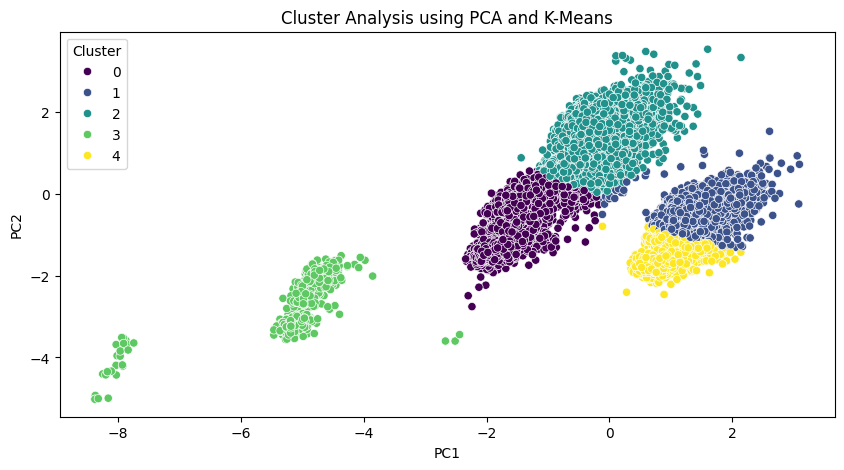

In [25]:
# Apply K-Means clustering
num_clusters = 5  # Set number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
pca_df['Cluster'] = kmeans.fit_predict(features_pca)

# Plot clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x='PC1', y='PC2', hue=pca_df['Cluster'], palette='viridis', data=pca_df)
plt.title('Cluster Analysis using PCA and K-Means')
plt.show()

# Select top 10,000 anomalous patients from the largest clusters
top_clusters = pca_df['Cluster'].value_counts().index[:3]  # Choose top 3 largest clusters
filtered_anomalous_patients = pca_df[pca_df['Cluster'].isin(top_clusters)].head(10000)
filtered_anomalous_patients.to_csv("final_anomalous_patients.csv", index=False)

#### 3. Graph-based Analysis

In [32]:
import networkx as nx
import pandas as pd
from networkx.algorithms import community

# Load transaction data
transactions = pd.concat([Transaction, Review_transaction])

# Create a graph (Undirected or Directed for efficiency)
G = nx.Graph()

# Add edges efficiently using a list (faster than iterrows)
edges = list(zip(transactions['id'], transactions['global_proc_id']))
G.add_edges_from(edges)

# Remove low-degree nodes (reduce graph size)
low_degree_nodes = [node for node, degree in G.degree() if degree < 2]
G.remove_nodes_from(low_degree_nodes)


In [33]:
import networkx as nx
import scipy.sparse as sp
from networkx.algorithms import community
from networkx.algorithms.community import louvain_communities
import numpy as np

# 🔹 Keep only the most active 10,000 patients
top_patients = [node for node, degree in sorted(G.degree(), key=lambda x: x[1], reverse=True)[:10000]]
G = G.subgraph(top_patients).copy()

# 🔹 Further reduce by keeping k-core (removes weak connections)
G = nx.k_core(G, k=3)  # Adjust k for better filtering

# 🔹 Convert to Scipy Sparse Matrix for faster processing
adj_matrix = nx.to_scipy_sparse_array(G, dtype=np.float32)

# 🔹 Run faster community detection (Louvain)
communities = louvain_communities(G, weight='weight', resolution=1.0)

# 🔹 Convert to a dictionary mapping patient IDs to clusters
community_mapping = {}
for i, community in enumerate(communities):
    for node in community:
        community_mapping[node] = i

# 🔹 Assign cluster labels to patients
clustered_patients = pd.DataFrame({
    'id': list(community_mapping.keys()),
    'cluster': list(community_mapping.values())
})

# 🔹 Save results
clustered_patients.to_csv("clustered_patients.csv", index=False)

print("Clustering completed! Results saved to clustered_patients.csv.")


Clustering completed! Results saved to clustered_patients.csv.


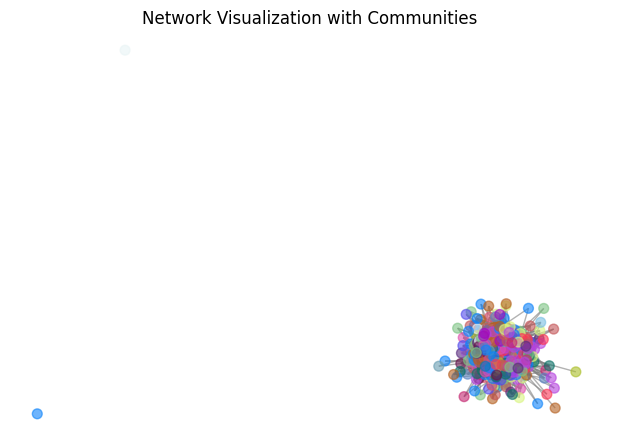

In [37]:
import random

# 🔹 Keep only the largest 500 nodes for visualization
largest_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:500]
subgraph = G.subgraph([node for node, _ in largest_nodes])

# 🔹 Assign colors to communities
num_clusters = len(set(community_mapping.values()))
colors = {cluster: (random.random(), random.random(), random.random()) for cluster in range(num_clusters)}

# 🔹 Get node colors based on their cluster
node_colors = [colors[community_mapping[node]] for node in subgraph.nodes()]

# 🔹 Draw the network
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(subgraph, seed=42)  # Layout for better spacing
nx.draw(subgraph, pos, node_size=50, node_color=node_colors, edge_color="gray", alpha=0.6, with_labels=False)
plt.title("Network Visualization with Communities")
plt.show()


In [ ]:
# Assign community labels to patients
community_mapping = {}
for idx, comm in enumerate(communities):
    for node in comm:
        if isinstance(node, int):  # Only assign to patient IDs
            community_mapping[node] = idx

# Add community labels to PCA dataframe
pca_df['Community'] = pca_df['id'].map(community_mapping)

# Visualize the network (sample)
plt.figure(figsize=(10, 6))
subgraph = G.subgraph(list(pca_df['id'].sample(500)))  # Sample 500 nodes for visualization
nx.draw(subgraph, with_labels=False, node_size=30)
plt.title("Graph-Based Patient Relationship Network")
plt.show()


# Previous Trial 1

In [10]:
# Merge patient data with transactions
Review_data = Review_patient.merge(Review_transaction, on='id', how='left')  # Reviewed patients
Unclassified_data = Patient_history.merge(Transaction, on='id', how='left')  # Unmarked patients

In [11]:
print(f"Review_data:\n {Review_data.head(2)}")
print(f"\nUnclassified_data:\n {Unclassified_data.head(2)}")

Review_data:
           id    age gender       income  global_proc_id  count
0  381693273  65-74      F  24000-31999              53      1
1  381693273  65-74      F  24000-31999              84      1

Unclassified_data:
           id    age gender       income  global_proc_id  count
0  306535165  65-74      F  24000-31999              25      1
1  306535165  65-74      F  24000-31999              26      1


### 2. EDA

In [13]:
# Summary statistics
print("Reviewed Patients Summary:")
print(Review_data.describe())

Reviewed Patients Summary:
                 id  global_proc_id    count
count  1.504100e+04    15041.000000  15041.0
mean   5.042027e+08       77.795825      1.0
std    2.850573e+08       31.672388      0.0
min    6.582200e+04        1.000000      1.0
25%    2.597743e+08       52.000000      1.0
50%    5.080220e+08       79.000000      1.0
75%    7.487934e+08      102.000000      1.0
max    9.999216e+08      130.000000      1.0


In [14]:
print("\nUnclassified Patients Summary:")
print(Unclassified_data.describe())


Unclassified Patients Summary:
                 id  global_proc_id      count
count  1.499768e+06    1.499768e+06  1499768.0
mean   5.000293e+08    3.808154e+01        1.0
std    2.884006e+08    3.098360e+01        0.0
min    7.561000e+03    1.000000e+00        1.0
25%    2.503668e+08    2.200000e+01        1.0
50%    4.998461e+08    2.600000e+01        1.0
75%    7.493660e+08    3.800000e+01        1.0
max    9.999957e+08    1.300000e+02        1.0


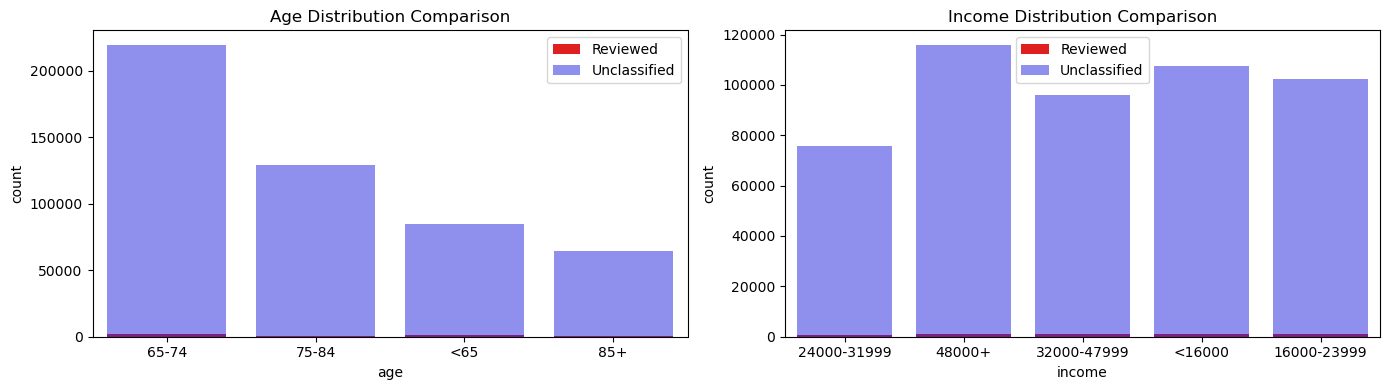

In [15]:
# Distribution of age and income
# Set up a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Age Distribution
sns.countplot(x='age', data=Review_patient, color='red', label='Reviewed', ax=axes[0])
sns.countplot(x='age', data=Patient_history, color='blue', label='Unclassified', alpha=0.5, ax=axes[0])
axes[0].set_title("Age Distribution Comparison")
axes[0].legend()

# Income Distribution
sns.countplot(x='income', data=Review_patient, color='red', label='Reviewed', ax=axes[1])
sns.countplot(x='income', data=Patient_history, color='blue', label='Unclassified', alpha=0.5, ax=axes[1])
axes[1].set_title("Income Distribution Comparison")
axes[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [16]:
# Age Distribution Counts
print("Reviewed Patients - Age Distribution:")
print(Review_patient['age'].value_counts())

print("\nUnclassified Patients - Age Distribution:")
print(Patient_history['age'].value_counts())

# Income Distribution Counts
print("\nReviewed Patients - Income Distribution:")
print(Review_patient['income'].value_counts())

print("\nUnclassified Patients - Income Distribution:")
print(Patient_history['income'].value_counts())

Reviewed Patients - Age Distribution:
age
65-74    2188
75-84    1247
<65       884
85+       655
Name: count, dtype: int64

Unclassified Patients - Age Distribution:
age
65-74    219329
75-84    128992
<65       84568
85+       64581
Name: count, dtype: int64

Reviewed Patients - Income Distribution:
income
48000+         1184
<16000         1104
16000-23999    1062
32000-47999     884
24000-31999     740
Name: count, dtype: int64

Unclassified Patients - Income Distribution:
income
48000+         115865
<16000         107543
16000-23999    102492
32000-47999     95899
24000-31999     75670
Name: count, dtype: int64


C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


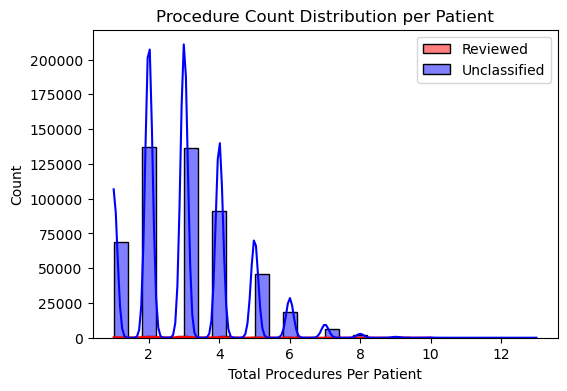

In [17]:
# Aggregate procedure count per patient
review_proc_per_patient = Review_transaction.groupby('id')['count'].sum()
unclassified_proc_per_patient = Transaction.groupby('id')['count'].sum()

# Plot the histogram
plt.figure(figsize=(6, 4))
sns.histplot(review_proc_per_patient, bins=30, color='red', label='Reviewed', kde=True)
sns.histplot(unclassified_proc_per_patient, bins=30, color='blue', label='Unclassified', kde=True, alpha=0.5)
plt.legend()
plt.title("Procedure Count Distribution per Patient")
plt.xlabel("Total Procedures Per Patient")
plt.show()


In [18]:
# Print the values
print("Reviewed Patients - Total Procedures Per Patient:")
print(review_proc_per_patient.describe())  # Summary statistics
print("\nFull Distribution:\n", review_proc_per_patient.value_counts().sort_index())

print("\nUnclassified Patients - Total Procedures Per Patient:")
print(unclassified_proc_per_patient.describe())  # Summary statistics
print("\nFull Distribution:\n", unclassified_proc_per_patient.value_counts().sort_index())


Reviewed Patients - Total Procedures Per Patient:
count    5000.000000
mean        3.008200
std         1.412987
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: count, dtype: float64

Full Distribution:
 count
1      672
2     1348
3     1341
4      923
5      444
6      187
7       70
8       10
9        4
10       1
Name: count, dtype: int64

Unclassified Patients - Total Procedures Per Patient:
count    505000.000000
mean          2.999622
std           1.416422
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          13.000000
Name: count, dtype: float64

Full Distribution:
 count
1      68510
2     137110
3     136087
4      90792
5      45759
6      18322
7       6116
8       1772
9        411
10        98
11        21
12         1
13         1
Name: count, dtype: int64


## Step 3: Anomaly Detection Approaches

### 1. Procedure Type Analysis (Association Rules / Frequency)
Objective: Identify if specific procedures are more frequent in reviewed patients.

In [21]:
# Count frequency of procedures for reviewed and unclassified patients
review_proc_freq = Review_transaction['global_proc_id'].value_counts()
unclassified_proc_freq = Transaction['global_proc_id'].value_counts()

# Display top 10 most common procedures in both groups
print("Top Procedures - Reviewed Patients:\n", review_proc_freq.head(10))
print("\nTop Procedures - Unclassified Patients:\n", unclassified_proc_freq.head(10))

Top Procedures - Reviewed Patients:
 global_proc_id
99     1120
124     859
58      412
69      391
97      369
122     329
70      325
92      314
48      305
47      283
Name: count, dtype: int64

Top Procedures - Unclassified Patients:
 global_proc_id
26    291815
25    189441
27    148554
17     72515
19     62283
28     39296
22     36891
20     35371
34     33719
13     28510
Name: count, dtype: int64


#### Step 1: Prepare Data for Apriori

#### Step 2: Apply Apriori

In [24]:
import mlxtend
print(mlxtend.__version__)

0.23.4


In [45]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Convert transactions into a list of procedures per patient
review_proc_list = Review_transaction.groupby('id')['global_proc_id'].apply(list).tolist()

# Encode transactions for Apriori
te = TransactionEncoder()
te_array = te.fit(review_proc_list).transform(review_proc_list)
df_apriori = pd.DataFrame(te_array, columns=te.columns_)

# Find frequent itemsets
frequent_itemsets = apriori(df_apriori, min_support=0.005, use_colnames=True)

# Extract association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Display top 10 association rules
print(rules.sort_values(by="lift", ascending=False).head(10))


Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


#### New Approach: Procedure Co-Occurrence Matrix

**a. Convert Transactions to Patient-Level**

In [52]:
# Merge transactions with patient history to get patient-level data
review_patient_procedures = Review_transaction.merge(Review_patient, on="id", how="left")
unclassified_patient_procedures = Transaction.merge(Patient_history, on="id", how="left")

# Create a pivot table for co-occurrence
review_pivot = review_patient_procedures.pivot_table(index="id", columns="global_proc_id", values="count", aggfunc="sum").fillna(0)
unclassified_pivot = unclassified_patient_procedures.pivot_table(index="id", columns="global_proc_id", values="count", aggfunc="sum").fillna(0)

# Convert to binary format (1 = procedure occurred, 0 = not)
review_pivot = (review_pivot > 0).astype(int)
unclassified_pivot = (unclassified_pivot > 0).astype(int)


**b. Compute Procedure Co-Occurrence**

In [54]:
# Compute co-occurrence matrix for reviewed patients
review_co_occurrence = review_pivot.T.dot(review_pivot)

# Compute co-occurrence matrix for unclassified patients
unclassified_co_occurrence = unclassified_pivot.T.dot(unclassified_pivot)

# Normalize by diagonal (self-occurrence)
for matrix in [review_co_occurrence, unclassified_co_occurrence]:
    diag_values = np.diag(matrix)
    matrix = matrix / diag_values[:, None]  # Normalize

print("Top 10 most common co-occurring procedures in Reviewed Patients:\n", review_co_occurrence.stack().sort_values(ascending=False).head(10))
print("\nTop 10 most common co-occurring procedures in Unclassified Patients:\n", unclassified_co_occurrence.stack().sort_values(ascending=False).head(10))


Top 10 most common co-occurring procedures in Reviewed Patients:
 global_proc_id  global_proc_id
99              99                1120
124             124                859
58              58                 412
69              69                 391
97              97                 369
122             122                329
70              70                 325
92              92                 314
48              48                 305
47              47                 283
dtype: int32

Top 10 most common co-occurring procedures in Unclassified Patients:
 global_proc_id  global_proc_id
26              26                291815
25              25                189441
27              27                148554
25              26                112188
26              25                112188
                27                 87745
27              26                 87745
17              17                 72515
19              19                 62283
25              27           

### 2. Provider-Patient Relationship Analysis
Objective: Check if some providers are linked more to reviewed patients

    Identify Providers in Transactions
    Count Unique Patients (Reviewed & unreviewed) Per Provider
    Compute the Proportion of Reviewed Patients
    Flag Providers with Suspicious Ratios
    Identify providers with an unusually high ratio of reviewed patients (might indicate fraudulent behavior)

In [59]:
# 1. Link Transactions to Providers (if provider info is available)
# Assume `Transaction` and `Review_transaction` contain 'provider_id' (If not, we may need to link with provider datasets)
Transaction_merged = Transaction.merge(Provider_Charge_In[['Provider Id']], left_on='id', right_on='Provider Id', how='left')
Review_transaction_merged = Review_transaction.merge(Provider_Charge_In[['Provider Id']], left_on='id', right_on='Provider Id', how='left')

# 2. Count Patients Per Provider
reviewed_patients_per_provider = Review_transaction_merged.groupby('Provider Id')['id'].nunique()
unclassified_patients_per_provider = Transaction_merged.groupby('Provider Id')['id'].nunique()

# 3. Compute Reviewed Patient Ratio
provider_review_ratio = (reviewed_patients_per_provider / (reviewed_patients_per_provider + unclassified_patients_per_provider)).fillna(0)

# 4. Flag Suspicious Providers
suspicious_providers = provider_review_ratio[provider_review_ratio > 0.5]  # Example: More than 50% reviewed patients

# Display Top Suspicious Providers
print("Top Suspicious Providers:\n", suspicious_providers.sort_values(ascending=False).head(10))


Top Suspicious Providers:
 Series([], Name: id, dtype: float64)


In [61]:
print(Transaction.columns)  
print(Review_transaction.columns)

Index(['id', 'global_proc_id', 'count'], dtype='object')
Index(['id', 'global_proc_id', 'count'], dtype='object')


In [63]:
print(Provider_Charge_In.columns)
print(Provider_Charge_Out.columns)

Index(['DRG Definition', 'Provider Id', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Hospital Referral Region (HRR) Description',
       'Total Discharges', 'Average Covered Charges', 'Average Total Payments',
       'Average Medicare Payments'],
      dtype='object')
Index(['APC', 'Provider Id', 'Provider Name', 'Provider Street Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
       'Hospital Referral Region (HRR) Description', 'Outpatient Services',
       'Average  Estimated Submitted Charges', 'Average Total Payments'],
      dtype='object')


In [65]:
Provider_Charge_In['DRG Code'] = Provider_Charge_In['DRG Definition'].str.extract(r'(\d+)')  # Extract numeric code
Provider_Charge_In['DRG Code'] = Provider_Charge_In['DRG Code'].astype(float)  # Convert to numeric

Provider_Charge_Out['APC Code'] = Provider_Charge_Out['APC'].astype(float)  # Convert APC to numeric

ValueError: could not convert string to float: '0012 - Level I Debridement & Destruction'

### 3. Clustering to Identify High-Risk Patient Groups
Objective: Find groups of patients that are distinct from normal patterns.